<a href="https://colab.research.google.com/github/Gaabiin5/Hugging_Face_Formation/blob/main/agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent

In this notebook, **we're going to build a simple agent using using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

As seen in the Unit 1, an agent needs 3 steps as introduced in the ReAct architecture :
[ReAct](https://react-lm.github.io/), a general agent architecture.

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

In [ ]:
%pip install -q -U langchain_openai langchain_core langgraph

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.environ.get("OPENAI_API_KEY")

# Please setp your own key.
# os.environ["OPENAI_API_KEY"] = "sk-xxxxxx"

In [8]:
import base64
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(model="gpt-4o")


def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""


llm = ChatOpenAI(model="gpt-4o")


def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b


tools = [
    divide,
    extract_text
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [9]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The input document
    input_file: Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


def assistant(state: AgentState):
    # System message
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image = state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computatio without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}

We define a `tools` node with our list of tools.

The `assistant` node is just our model with bound tools.

We create a graph with `assistant` and `tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `tools` based on  whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `tools` node *back* to the `assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

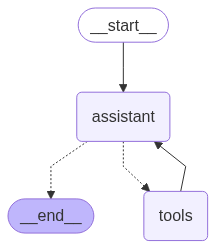

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages, "input_file": None})

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [6]:
for m in messages['messages']:
    m.pretty_print()

TypeError: list indices must be integers or slices, not str

## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner left in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [ ]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]

messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [ ]:
for m in messages['messages']:
    m.pretty_print()